In [42]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor


# Set seaborn style
sns.set_style("whitegrid")

In [43]:
# Load the dataset
df_demo = pd.read_csv("Demographic.csv")

# Save original copy before encoding or scaling
df_original = df_demo.copy()

In [44]:
# Encode Gender (Binary)
label_encoder = LabelEncoder()
df_demo['Gender'] = label_encoder.fit_transform(df_demo['Gender'])


In [45]:
# One-Hot Encoding for categorical variables
categorical_columns = ['Location', 'Ad Type', 'Ad Topic', 'Ad Placement']
df_demo = pd.get_dummies(df_demo, columns=categorical_columns, drop_first=True)


In [46]:
# Standardize numerical features
scaler = StandardScaler()
numerical_columns = ['Age', 'Income', 'Clicks', 'CTR', 'Conversion Rate']
df_demo[numerical_columns] = scaler.fit_transform(df_demo[numerical_columns])


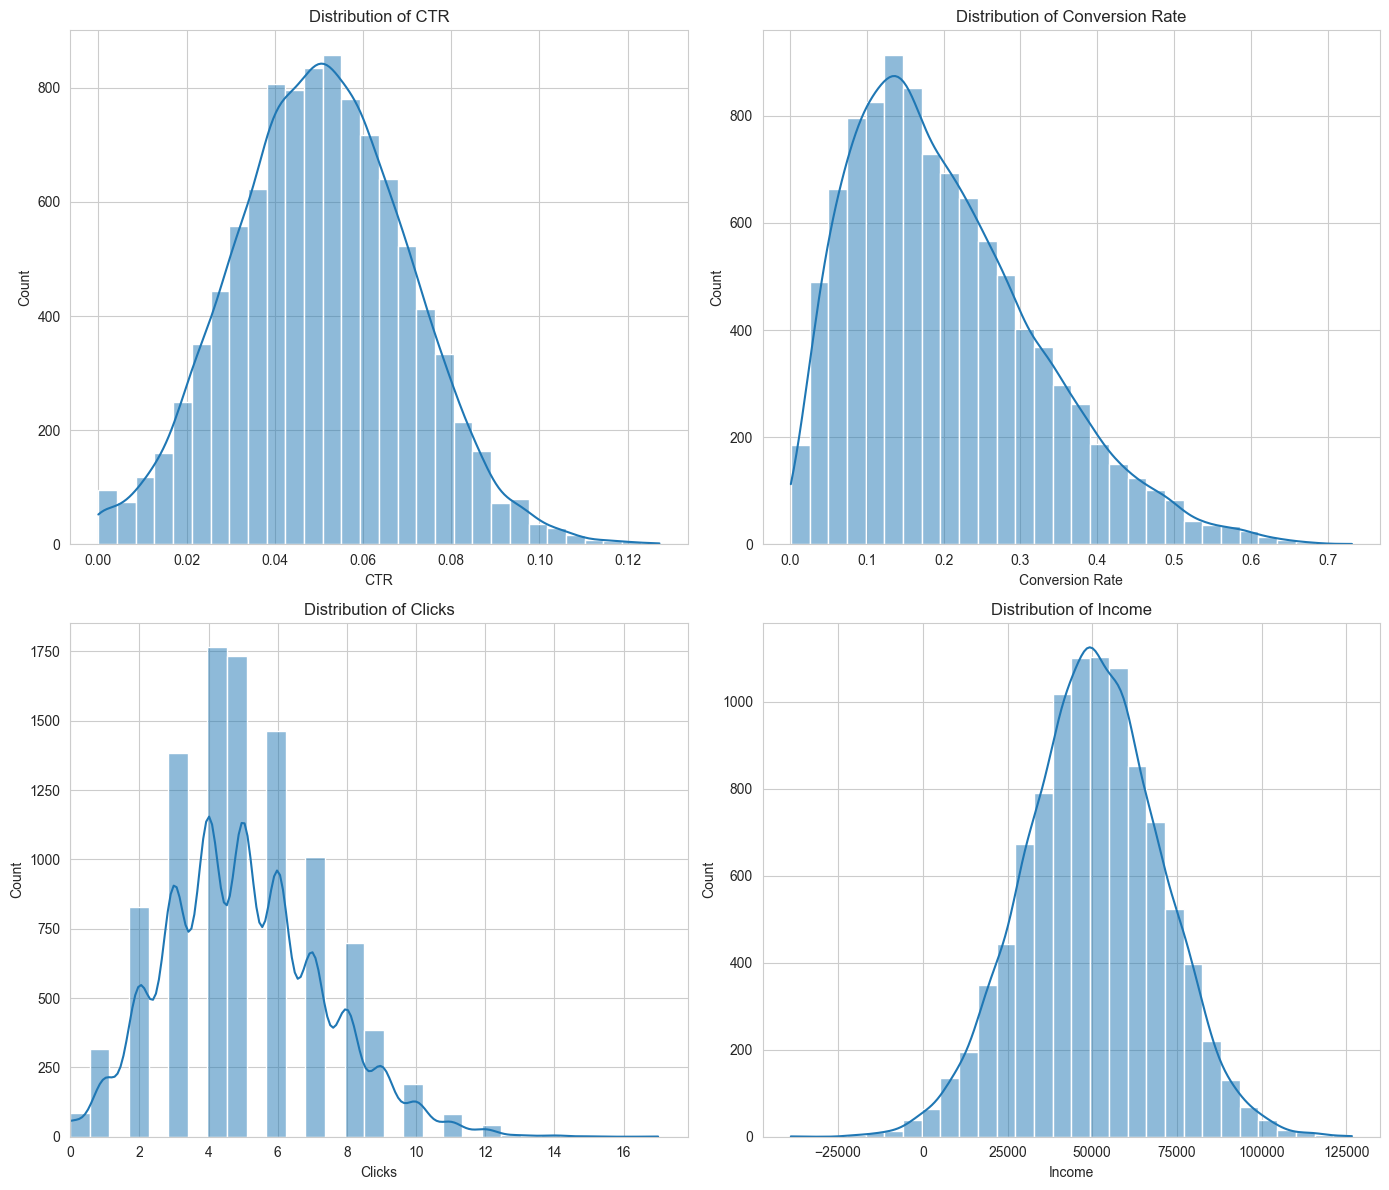

In [47]:

# --- Exploratory Data Analysis ---

# Plotting original CTR, Conversion Rate, Clicks, Income
distribution_features = ['CTR', 'Conversion Rate', 'Clicks', 'Income']
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, feature in enumerate(distribution_features):
    sns.histplot(df_original[feature], bins=30, kde=True, ax=axes[idx//2, idx%2])
    axes[idx//2, idx%2].set_title(f"Distribution of {feature}")
    if feature == 'Clicks':
        axes[idx//2, idx%2].set_xlim(0, None)

plt.tight_layout()
plt.show()


20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


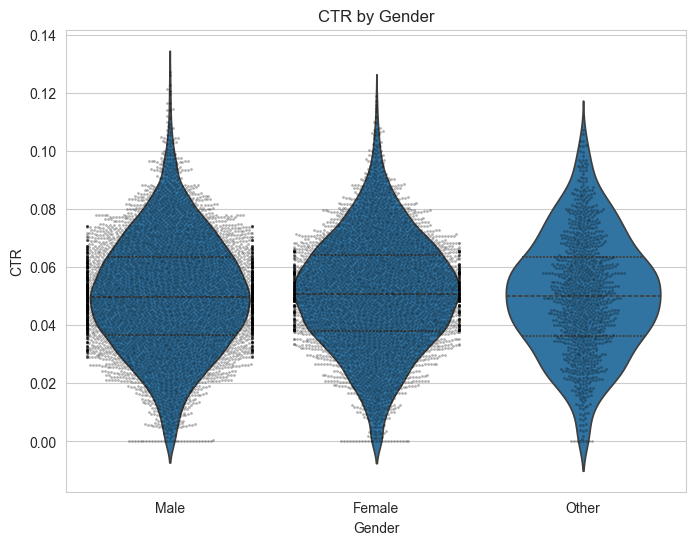

5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


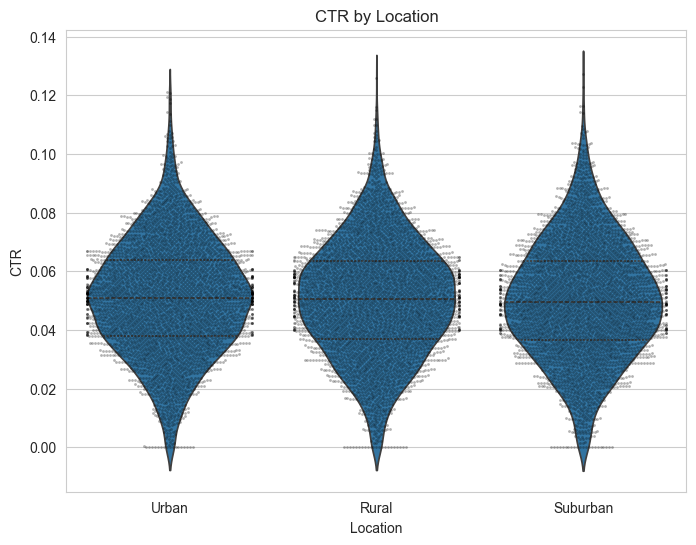

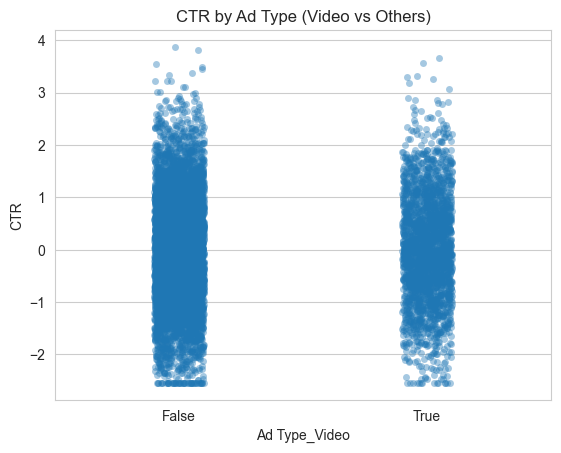

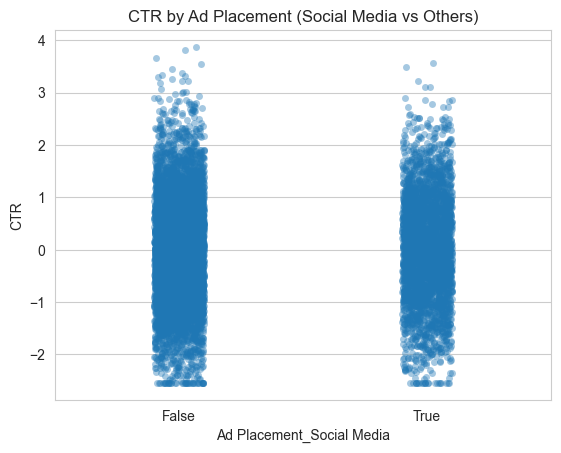

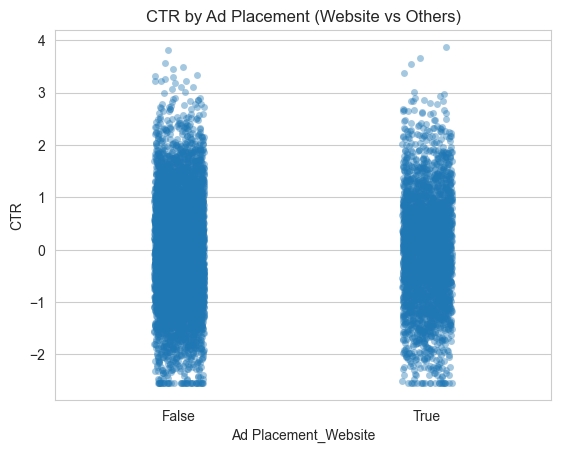

In [48]:

# CTR Analysis by Categorical Features (using original CTR)
plt.figure(figsize=(8, 6))
sns.violinplot(x='Gender', y='CTR', data=df_original, inner='quartile')
sns.swarmplot(x='Gender', y='CTR', data=df_original, color='k', alpha=0.3, size=2)
plt.title('CTR by Gender')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(x='Location', y='CTR', data=df_original, inner='quartile')
sns.swarmplot(x='Location', y='CTR', data=df_original, color='k', alpha=0.3, size=2)
plt.title('CTR by Location')
plt.show()

sns.stripplot(x='Ad Type_Video', y='CTR', data=df_demo, jitter=True, alpha=0.4)
plt.title('CTR by Ad Type (Video vs Others)')
plt.show()

sns.stripplot(x='Ad Placement_Social Media', y='CTR', data=df_demo, jitter=True, alpha=0.4)
plt.title('CTR by Ad Placement (Social Media vs Others)')
plt.show()

sns.stripplot(x='Ad Placement_Website', y='CTR', data=df_demo, jitter=True, alpha=0.4)
plt.title('CTR by Ad Placement (Website vs Others)')
plt.show()

21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


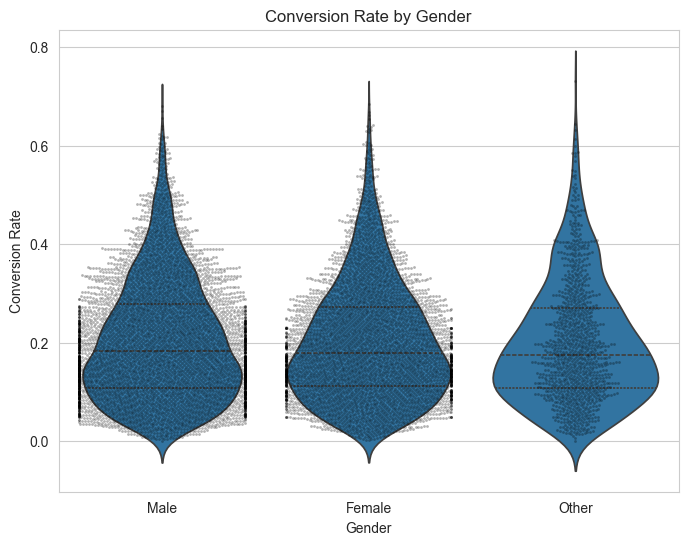

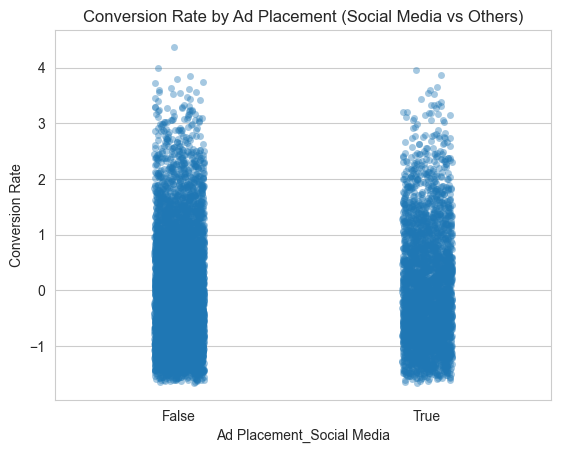

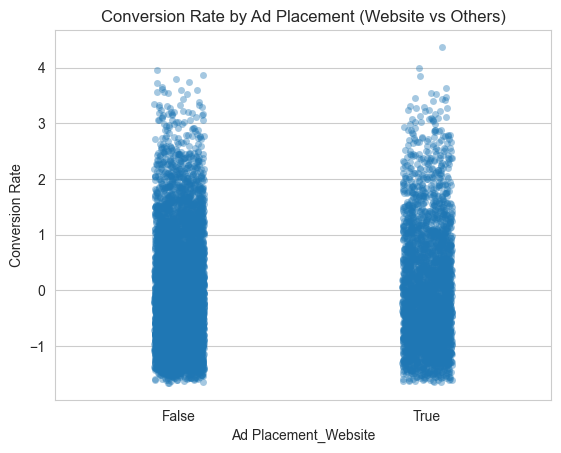

In [50]:
# Conversion Rate Analysis (original)
plt.figure(figsize=(8, 6))
sns.violinplot(x='Gender', y='Conversion Rate', data=df_original, inner='quartile')
sns.swarmplot(x='Gender', y='Conversion Rate', data=df_original, color='k', alpha=0.3, size=2)
plt.title('Conversion Rate by Gender')
plt.show()

sns.stripplot(x='Ad Placement_Social Media', y='Conversion Rate', data=df_demo, jitter=True, alpha=0.4)
plt.title('Conversion Rate by Ad Placement (Social Media vs Others)')
plt.show()

sns.stripplot(x='Ad Placement_Website', y='Conversion Rate', data=df_demo, jitter=True, alpha=0.4)
plt.title('Conversion Rate by Ad Placement (Website vs Others)')
plt.show()

In [51]:
# --- Causal Analysis ---
# Define treatment and control groups based on clicks
df_demo['Treatment'] = (df_demo['Clicks'] > 0).astype(int)

# Check distribution of treatment and control groups
treatment_distribution = df_demo['Treatment'].value_counts(normalize=True)
print(df_demo[['Clicks', 'Treatment']].head())
print("Treatment vs Control Distribution:\n", treatment_distribution)

# Propensity Score Matching
covariates = ['Age', 'Gender', 'Income', 'Location_Suburban', 'Location_Urban',
              'Ad Type_Native', 'Ad Type_Text', 'Ad Type_Video',
              'Ad Topic_Finance', 'Ad Topic_Food', 'Ad Topic_Health', 'Ad Topic_Technology', 'Ad Topic_Travel',
              'Ad Placement_Social Media', 'Ad Placement_Website']

logit = LogisticRegression(solver='liblinear')
df_demo['Propensity_Score'] = logit.fit(df_demo[covariates], df_demo['Treatment']).predict_proba(df_demo[covariates])[:, 1]


     Clicks  Treatment
0 -0.899318          0
1 -0.013552          0
2 -0.456435          0
3  0.429331          1
4 -0.013552          0
Treatment vs Control Distribution:
 Treatment
0    0.6111
1    0.3889
Name: proportion, dtype: float64


In [52]:
# Nearest Neighbor Matching

treated = df_demo[df_demo['Treatment'] == 1]
control = df_demo[df_demo['Treatment'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['Propensity_Score']])
distances, indices = nn.kneighbors(treated[['Propensity_Score']])
matched_controls = control.iloc[indices.flatten()]

matched_data = pd.concat([treated, matched_controls])
print(matched_data[['Age', 'Gender', 'Income', 'Clicks', 'Click Time', 'Conversion Rate', 'CTR']].head())

# Check balance
balance = matched_data[['Propensity_Score', 'Treatment']].groupby('Treatment').mean()
print("Balance Check After Matching:\n", balance)


         Age  Gender    Income    Clicks                  Click Time  \
3   2.282946       0  0.727655  0.429331  2023-12-13 20:45:56.898459   
6   0.998295       0  0.707053  0.429331  2023-09-09 20:45:56.898459   
9   0.457390       1  1.494941  0.429331  2023-07-25 20:45:56.898459   
11  1.471588       1  1.718355  1.315096  2024-01-03 20:45:56.898459   
16  1.539201       0 -1.023234  2.200862  2023-12-07 20:45:56.898459   

    Conversion Rate       CTR  
3         -0.743638 -1.373619  
6          0.121847 -0.611751  
9         -1.034335 -1.191982  
11        -0.315850  1.376170  
16        -0.687480  0.170299  
Balance Check After Matching:
            Propensity_Score
Treatment                  
0                  0.390233
1                  0.390233


In [53]:
# Average Treatment Effect (ATE)
ate = matched_data[matched_data['Treatment'] == 1]['Conversion Rate'].mean() - \
      matched_data[matched_data['Treatment'] == 0]['Conversion Rate'].mean()

print("Estimated Average Treatment Effect (ATE):", round(ate, 6))


Estimated Average Treatment Effect (ATE): 0.023494


In [54]:
# Heterogeneous Treatment Effects (HTE)
X = matched_data[covariates]
Y = matched_data['Conversion Rate']
T = matched_data['Treatment']

estimator = CausalForestDML(
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    cv=3,
    random_state=42
)

estimator.fit(Y, T, X=X)
hte_predictions = estimator.effect(X)
matched_data['HTE_Estimate'] = hte_predictions

print(matched_data[['Age', 'Gender', 'Income', 'HTE_Estimate']].head())
print("\nSummary of HTE Estimates:\n", matched_data['HTE_Estimate'].describe())


First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!


         Age  Gender    Income  HTE_Estimate
3   2.282946       0  0.727655      0.025946
6   0.998295       0  0.707053      0.126731
9   0.457390       1  1.494941     -0.113637
11  1.471588       1  1.718355      0.113067
16  1.539201       0 -1.023234     -0.020364

Summary of HTE Estimates:
 count    7778.000000
mean        0.030225
std         0.180794
min        -0.798893
25%        -0.080164
50%         0.041241
75%         0.151789
max         0.587203
Name: HTE_Estimate, dtype: float64


7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
19.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


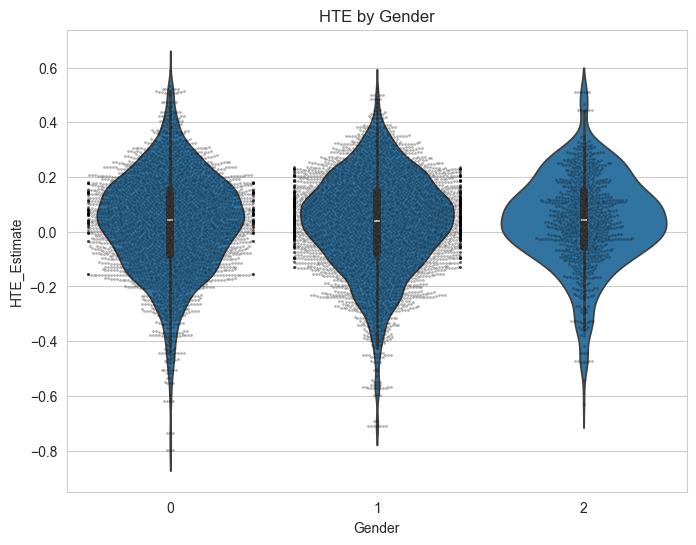

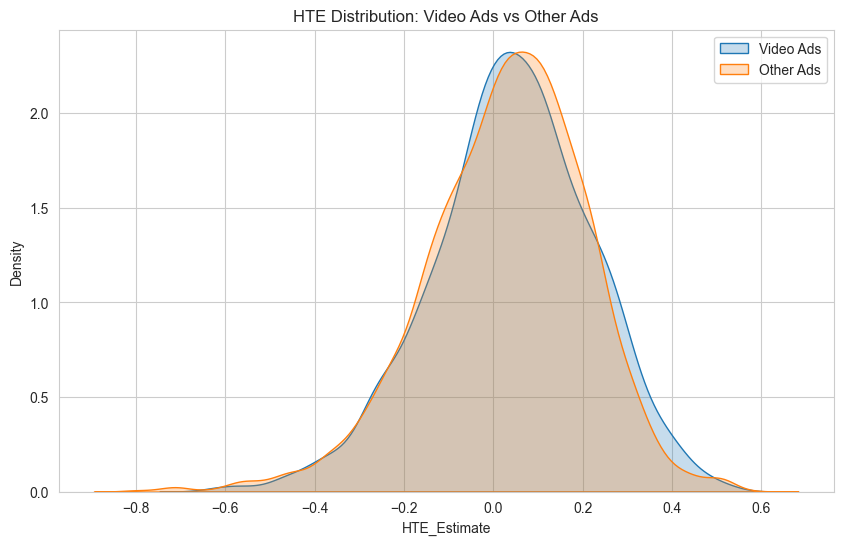

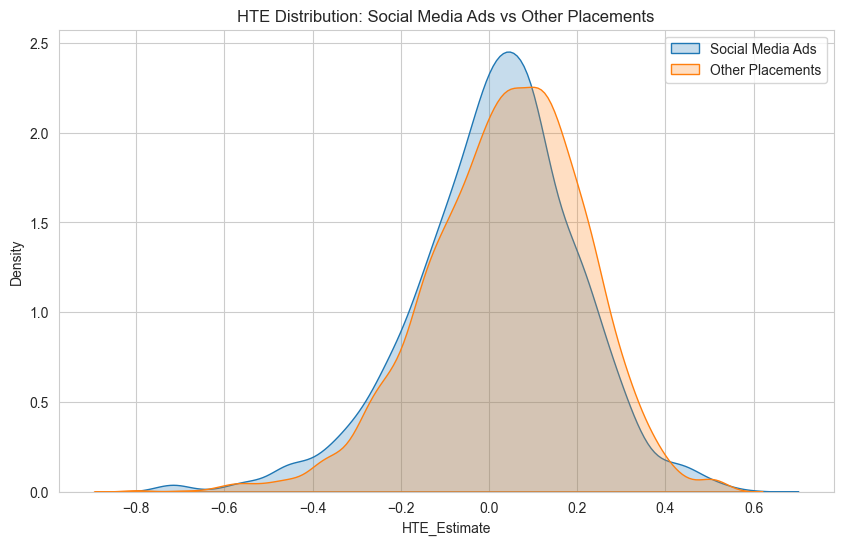

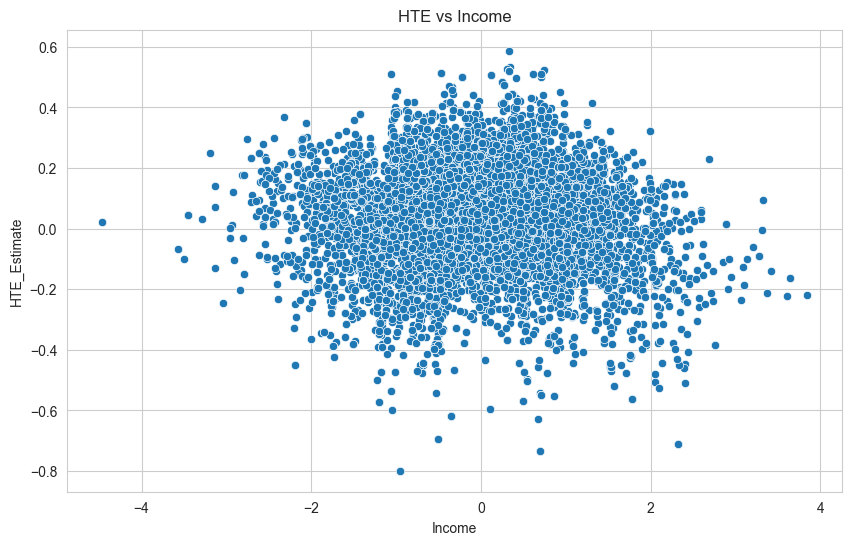

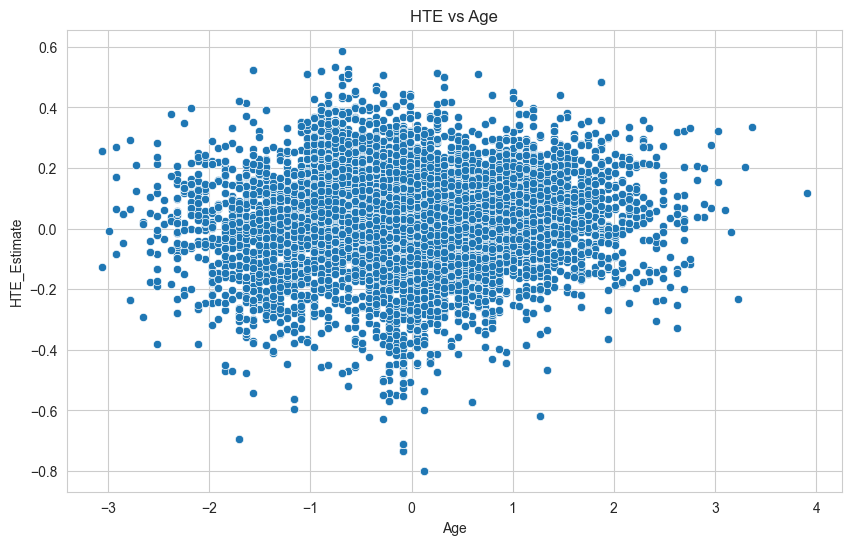

In [62]:
# --- HTE Visualizations ---
# Violin Plot: HTE by Gender
plt.figure(figsize=(8, 6))
sns.violinplot(x='Gender', y='HTE_Estimate', data=matched_data)
sns.swarmplot(x=matched_data['Gender'], y=matched_data['HTE_Estimate'], data=df_demo, color='k', alpha=0.3, size = 2)
plt.title('HTE by Gender')
plt.show()

# KDE Plot: HTE by Ad Type (Video vs Others)
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_data[matched_data['Ad Type_Video'] == 1]['HTE_Estimate'], label='Video Ads', fill=True)
sns.kdeplot(matched_data[matched_data['Ad Type_Video'] == 0]['HTE_Estimate'], label='Other Ads', fill=True)
plt.title('HTE Distribution: Video Ads vs Other Ads')
plt.legend()
plt.show()

# KDE Plot: HTE by Ad Placement (Social Media vs Others)
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_data[matched_data['Ad Placement_Social Media'] == 1]['HTE_Estimate'], label='Social Media Ads', fill=True)
sns.kdeplot(matched_data[matched_data['Ad Placement_Social Media'] == 0]['HTE_Estimate'], label='Other Placements', fill=True)
plt.title('HTE Distribution: Social Media Ads vs Other Placements')
plt.legend()
plt.show()

# Scatter Plot: HTE vs Income
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='HTE_Estimate', data=matched_data)
plt.title('HTE vs Income')
plt.show()

# Scatter Plot: HTE vs Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='HTE_Estimate', data=matched_data)
plt.title('HTE vs Age')
plt.show()


## Campaign Data

In [56]:
# Load the dataset
df_campaign = pd.read_csv("marketing_campaign_dataset.csv")

# Display the first few rows
print(df_campaign.head())

# Basic info
print(df_campaign.info())

# Missing values check
print(df_campaign.isnull().sum())


   Campaign_ID              Company Campaign_Type Target_Audience Duration  \
0            1  Innovate Industries         Email       Men 18-24  30 days   
1            2       NexGen Systems         Email     Women 35-44  60 days   
2            3    Alpha Innovations    Influencer       Men 25-34  30 days   
3            4   DataTech Solutions       Display        All Ages  60 days   
4            5       NexGen Systems         Email       Men 25-34  15 days   

  Channel_Used  Conversion_Rate Acquisition_Cost   ROI     Location  Language  \
0   Google Ads             0.04       $16,174.00  6.29      Chicago   Spanish   
1   Google Ads             0.12       $11,566.00  5.61     New York    German   
2      YouTube             0.07       $10,200.00  7.18  Los Angeles    French   
3      YouTube             0.11       $12,724.00  5.55        Miami  Mandarin   
4      YouTube             0.05       $16,452.00  6.50  Los Angeles  Mandarin   

   Clicks  Impressions  Engagement_Score    

In [57]:
df_campaign['Acquisition_Cost'] = df_campaign['Acquisition_Cost'].replace(r'[$,]', '', regex=True).astype(float)

# Convert ROI to float (if it's stored as string)
df_campaign['ROI'] = pd.to_numeric(df_campaign['ROI'], errors='coerce')


In [58]:
# Check for nulls
print(df_campaign.isnull().sum())

Campaign_ID         0
Company             0
Campaign_Type       0
Target_Audience     0
Duration            0
Channel_Used        0
Conversion_Rate     0
Acquisition_Cost    0
ROI                 0
Location            0
Language            0
Clicks              0
Impressions         0
Engagement_Score    0
Customer_Segment    0
Date                0
dtype: int64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



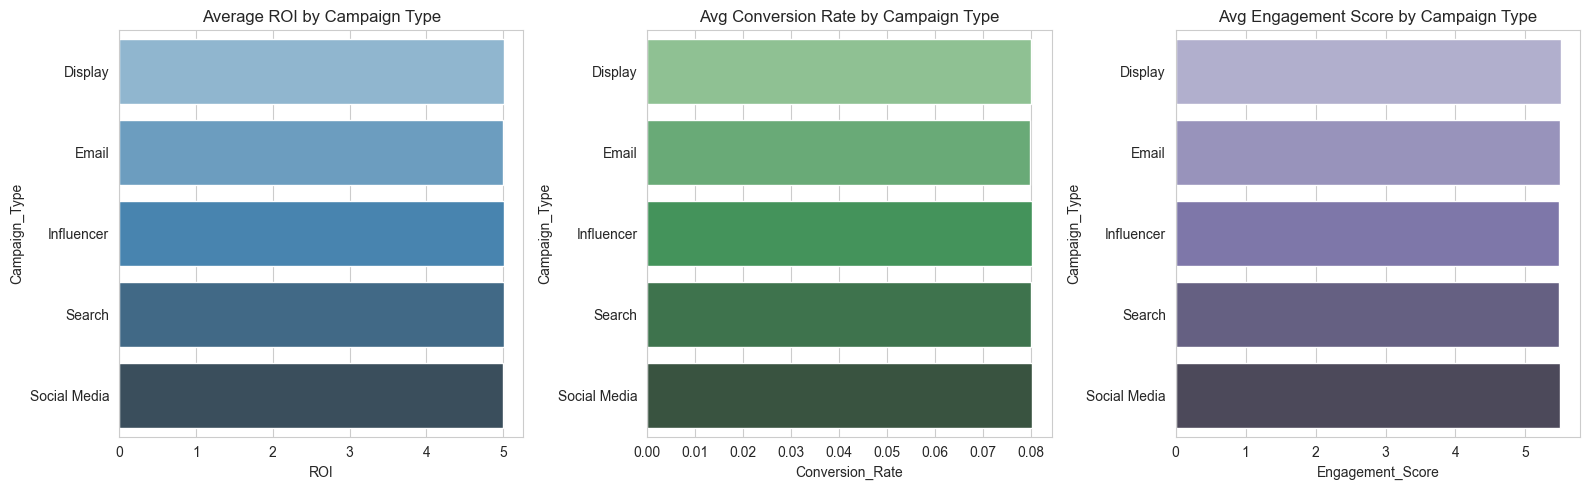

In [59]:
# Group by Campaign_Type and calculate means
campaign_summary = df_campaign.groupby("Campaign_Type")[["ROI", "Conversion_Rate", "Engagement_Score"]].mean().reset_index()

# Plotting
plt.figure(figsize=(16, 5))

# ROI
plt.subplot(1, 3, 1)
sns.barplot(x="ROI", y="Campaign_Type", data=campaign_summary, palette="Blues_d")
plt.title("Average ROI by Campaign Type")

# Conversion Rate
plt.subplot(1, 3, 2)
sns.barplot(x="Conversion_Rate", y="Campaign_Type", data=campaign_summary, palette="Greens_d")
plt.title("Avg Conversion Rate by Campaign Type")

# Engagement Score
plt.subplot(1, 3, 3)
sns.barplot(x="Engagement_Score", y="Campaign_Type", data=campaign_summary, palette="Purples_d")
plt.title("Avg Engagement Score by Campaign Type")

plt.tight_layout()
plt.show()


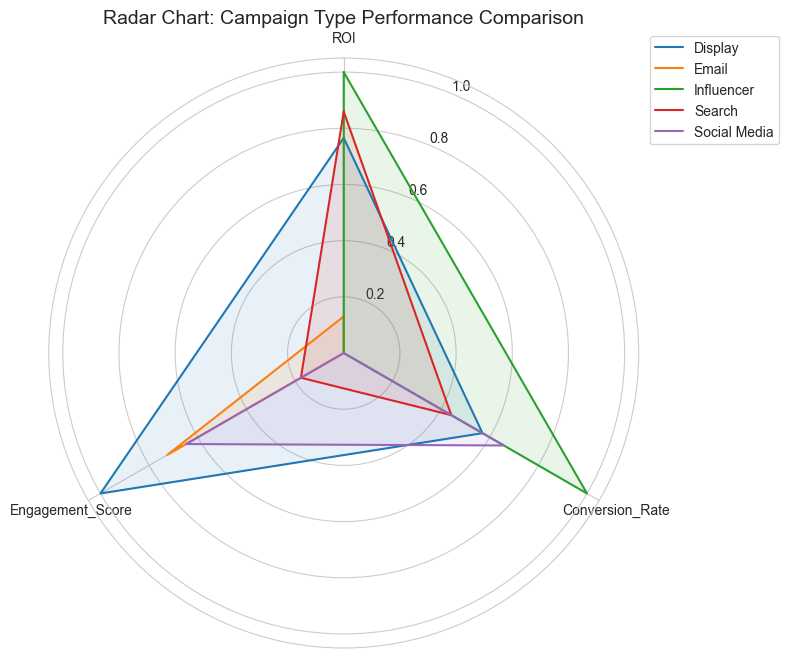

In [60]:
# Step 1: Group and summarize metrics
metrics = ['ROI', 'Conversion_Rate', 'Engagement_Score']
summary_df = df_campaign.groupby('Campaign_Type')[metrics].mean()

# Step 2: Normalize values (0 to 1 range) for fair comparison
normalized_df = (summary_df - summary_df.min()) / (summary_df.max() - summary_df.min())

# Step 3: Setup radar chart variables
categories = list(normalized_df.columns)
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Step 4: Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for campaign in normalized_df.index:
    values = normalized_df.loc[campaign].tolist()
    values += values[:1]  # close loop
    ax.plot(angles, values, label=campaign)
    ax.fill(angles, values, alpha=0.1)

# Step 5: Formatting
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
plt.title("Radar Chart: Campaign Type Performance Comparison", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



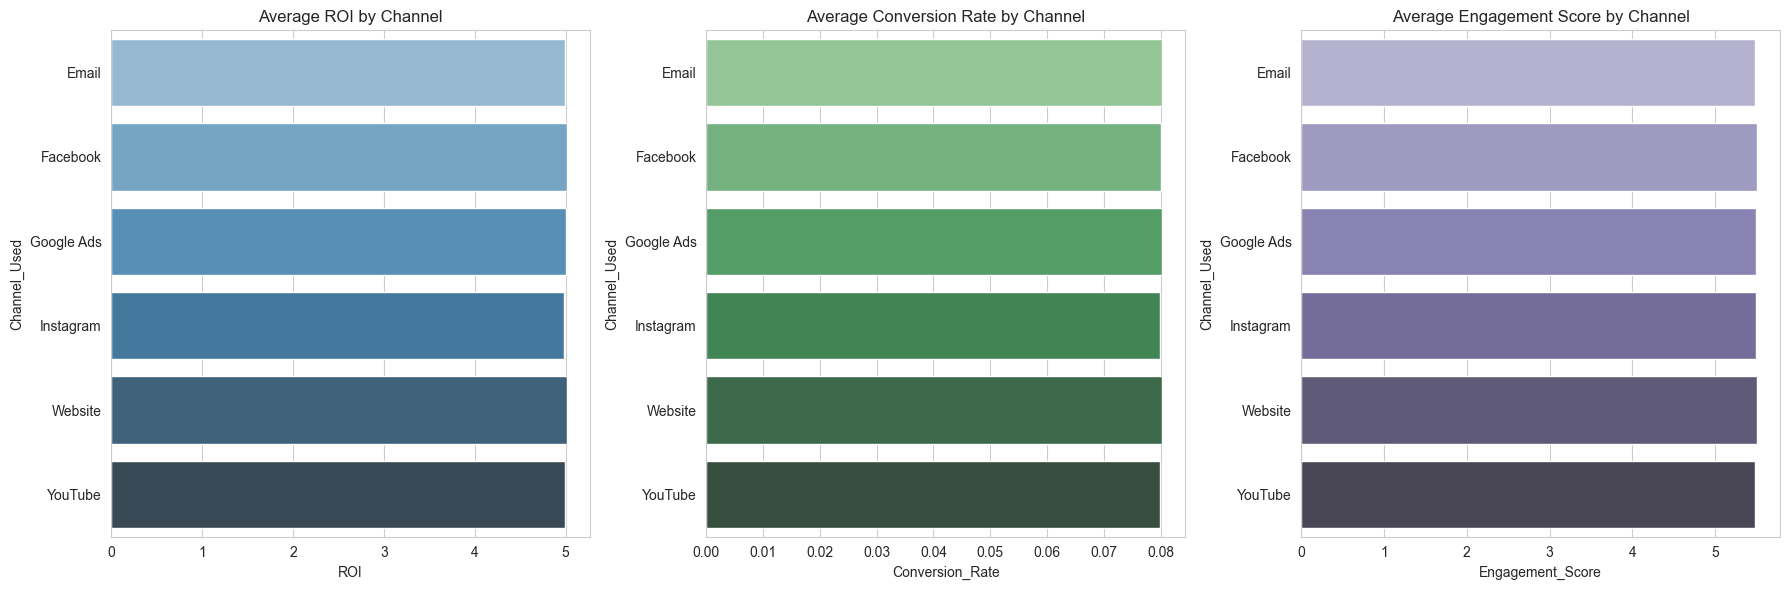

In [61]:
# Grouping and summarizing data
channel_summary = df_campaign.groupby("Channel_Used")[["ROI", "Conversion_Rate", "Engagement_Score"]].mean().reset_index()

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ROI
sns.barplot(x="ROI", y="Channel_Used", data=channel_summary, palette="Blues_d", ax=axes[0])
axes[0].set_title("Average ROI by Channel")

# Conversion Rate
sns.barplot(x="Conversion_Rate", y="Channel_Used", data=channel_summary, palette="Greens_d", ax=axes[1])
axes[1].set_title("Average Conversion Rate by Channel")

# Engagement Score
sns.barplot(x="Engagement_Score", y="Channel_Used", data=channel_summary, palette="Purples_d", ax=axes[2])
axes[2].set_title("Average Engagement Score by Channel")

plt.tight_layout()
plt.show()
